<h1 align="center">Analysis of Metadata and Text for Level and Group Classification</h1>

We have two classification tasks:

* Predict the level, which ranges from 1-16.
* Predict the group of a given text, given this mapping from levels to group:
  - Levels 1-3 = Group A1
  - Levels 4-6 = Group A2
  - Levels 7-9 = Group B1
  - Levels 10-12 = Group B2
  - Levels 13-15 = Group C1
  - Levels 16 = Group C2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd 
import numpy as np
import seaborn as sns

Here, we load the serialized DataFrame saved in step 1.

In [2]:
%%time
raw_input = pd.read_pickle('input.pkl')

CPU times: user 384 ms, sys: 360 ms, total: 744 ms
Wall time: 740 ms


In [3]:
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit
0,1,90,6,"After some time, the affection between them is...",41,Writing a movie plot,1
1,2,90,6,An e-ticket is a provement that you bought the...,42,Filling in an arrival card,2
2,3,86,6,From:xxx@1234.com To:Herman xxx@1234.com Date:...,43,Creating an office dress code,3
3,4,87,1,"Hi Anna ,How are you . My name's Jayla . My te...",1,Introducing yourself by email,1
4,5,95,1,"Dear Ms Thomas, There are thirty pens and fift...",2,Taking inventory in the office,2


In [4]:
raw_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180309 entries, 0 to 1180308
Data columns (total 7 columns):
article_id    1180309 non-null int64
grade         1180309 non-null int64
level         1180309 non-null int64
text          1180309 non-null object
topic_id      1180309 non-null int64
topic_text    1180309 non-null object
unit          1180309 non-null int64
dtypes: int64(5), object(2)
memory usage: 63.0+ MB


# Map Level to Group

Next We map the `level` column to `group` to prepare for the second classification task.`

In [5]:
gp_mapper = {
    1: 'A1', 2: 'A1', 3: 'A1',
    4: 'A2', 5: 'A2', 6: 'A2',
    7: 'B1', 8: 'B1', 9: 'B1',
    10: 'B2', 11: 'B2', 12: 'B2',
    13: 'C1', 14: 'C1', 15: 'C1',
    16: 'C2'
}

raw_input = raw_input.assign(group=raw_input.level.map(gp_mapper))    

In [6]:
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit,group
0,1,90,6,"After some time, the affection between them is...",41,Writing a movie plot,1,A2
1,2,90,6,An e-ticket is a provement that you bought the...,42,Filling in an arrival card,2,A2
2,3,86,6,From:xxx@1234.com To:Herman xxx@1234.com Date:...,43,Creating an office dress code,3,A2
3,4,87,1,"Hi Anna ,How are you . My name's Jayla . My te...",1,Introducing yourself by email,1,A1
4,5,95,1,"Dear Ms Thomas, There are thirty pens and fift...",2,Taking inventory in the office,2,A1


# Check for Class Imbalance

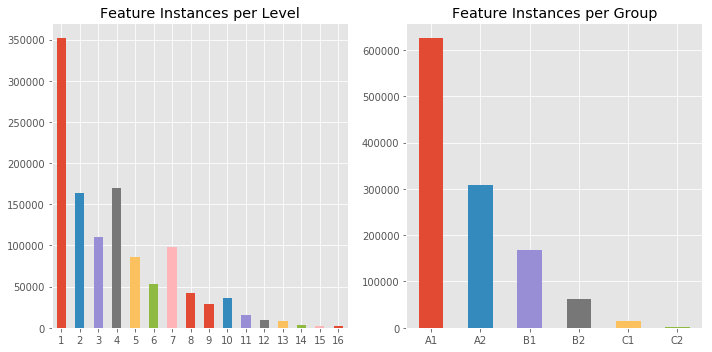

In [6]:
level_counts = raw_input.level.value_counts().sort_index()
group_counts = raw_input.group.value_counts().sort_index()

_, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = level_counts.plot(kind='bar', title='Feature Instances per Level', ax=ax[0], rot=0)
_ = group_counts.plot(kind='bar', title='Feature Instances per Group', ax=ax[1], rot=0)

plt.tight_layout()

# Level Classification Based on Text

Here we apply the same approach of converting text to bag-of-words features and then using a maximum entropy classifier. The difference is we are now running on the full dataset which is much larger. The optimizer now requires more steps to converge, so we change the `max_iters` attribute of `LogisticRegression` to 1000. We address the label imbalance by setting `class_weight='balanced'`.

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))
print(en_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
{"haven't", 'most', 'but', 'ain', 'themselves', 'have', 'just', 'had', 'at', 've', 'your', "hadn't", 'ma', 'having', "won't", 'has', 's', "hasn't", 'o', 'which', 'any', 'each', 'in', 'down', 'myself', "shouldn't", 'when', 'his', 'him', 'y', 'than', 'haven', 'theirs', 'won', 'once', "isn't", 'and', 'an', 'both', 'with', 'needn', 'them', 'doing', 'yourself', "that'll", 'over', "mustn't", 'been', 'off', 'we', "mightn't", 'its', 'through', 'too', 'herself', 'or', 'my', 'ours', 'for', 'few', 'up', 'he', 'i', 'no', 'what', 'if', 'aren', 'me', 'being', 'yourselves', 'why', "you'd", 'such', 'during', "doesn't", 'hers', 'shan', "aren't", 'now', 'doesn', "should've", 'am', 'before', 'then', 'hasn', 't', "weren't", 'as', 'do', 'here', 't

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


def display_results(y, y_pred):
    """Given some predications y_pred for a target label y, 
    display the precision/recall/f1 score and the confusion matrix."""
        
    report = classification_report(y_pred, y)
    print(report)

    level_values = y.unique()
    level_values.sort()
    cm = confusion_matrix(y_true=y, y_pred=y_pred.values, labels=level_values)
    cm = pd.DataFrame(index=level_values, columns=level_values, data=cm)

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax = sns.heatmap(cm, annot=True, ax=ax, fmt='d')

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold


def classify(input_df, target_label='level'):
    """
    Build a classifier for the `target_label` column in the DataFrame `input_df` using the `text` column.    
    Return the (labels, predicted_labels) tuple.    
    Use a 10-fold Stratified K-fold cross-validator to generate the out-of-sample predictions."""
    
    assert target_label in input_df.columns
    
    counter = CountVectorizer(
        lowercase=True, 
        stop_words=en_stopwords, 
        ngram_range=(1, 1),
        min_df=5,
        max_df=0.4,
        binary=True)

    model = LogisticRegression(
         # maximize log-likelihood + square norm of parameters
        penalty='l2',
        # steps required for the L-BFGS optimizer to converge, found by trial and error
        max_iter=1000, 
        # use softmax instead of one-vs-rest style classification
        multi_class='multinomial', 
        # use L-BFGS optimizer 
        solver='lbfgs',
        # This prints out a warning if the optimizer hasn't converged
        verbose=True, 
        # to handle the class imbalance
        # automatically adjust weights inversely proportional to 
        # class frequencies in the input data
        class_weight='balanced', 
        random_state=4321)
    
    pipeline = make_pipeline(counter, model)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

    X = input_df.text
    y = input_df.loc[:, target_label]
    y_pred = cross_val_predict(pipeline, X=X.values, y=y.values, cv=cv, n_jobs=10, verbose=2)
    y_pred = pd.Series(index=raw_input.index.copy(), data=y_pred)

    return y.copy(), y_pred

In [16]:
%%time
levels, levels_predicted = classify(raw_input, target_label='level')

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.8min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.7min finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 31.5min remaining: 73.4min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 30.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.6min finished


CPU times: user 12.8 s, sys: 7.36 s, total: 20.2 s
Wall time: 32min 37s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 32.6min finished


             precision    recall  f1-score   support

          1       0.97      0.98      0.98    349517
          2       0.96      0.96      0.96    164862
          3       0.94      0.93      0.94    111109
          4       0.95      0.97      0.96    166967
          5       0.94      0.94      0.94     85861
          6       0.95      0.94      0.94     53570
          7       0.94      0.95      0.95     96648
          8       0.90      0.87      0.89     43118
          9       0.92      0.90      0.91     29280
         10       0.94      0.94      0.94     36505
         11       0.88      0.84      0.86     16198
         12       0.90      0.87      0.88      9584
         13       0.91      0.90      0.90      8988
         14       0.84      0.81      0.83      3793
         15       0.75      0.73      0.74      2314
         16       0.81      0.79      0.80      1995

avg / total       0.95      0.95      0.95   1180309



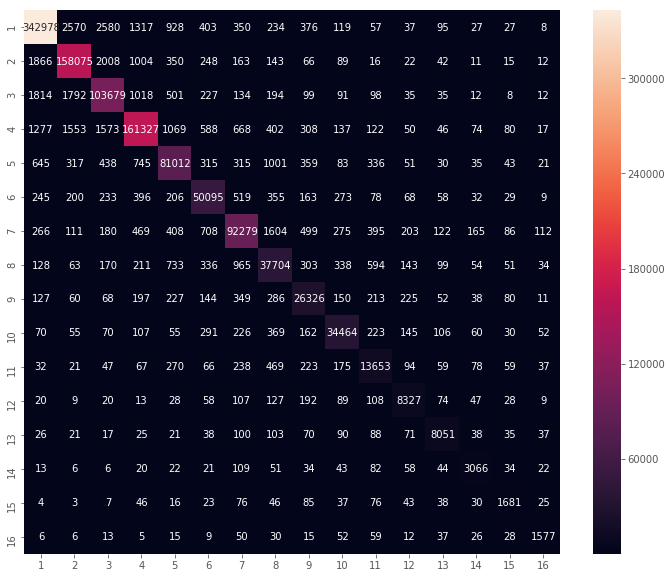

In [17]:
display_results(levels, levels_predicted)

# Group Classification Based on Text

In [10]:
%%time
groups, groups_predicted = classify(raw_input, target_label='group')

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.3min finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 25.3min remaining: 59.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.0min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.6min finished
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 26.5min finished


CPU times: user 11 s, sys: 7.04 s, total: 18.1 s
Wall time: 26min 32s


             precision    recall  f1-score   support

         A1       0.98      0.99      0.98    623310
         A2       0.95      0.96      0.95    306656
         B1       0.94      0.94      0.94    169243
         B2       0.93      0.90      0.91     63220
         C1       0.88      0.82      0.84     15773
         C2       0.81      0.75      0.78      2107

avg / total       0.96      0.96      0.96   1180309



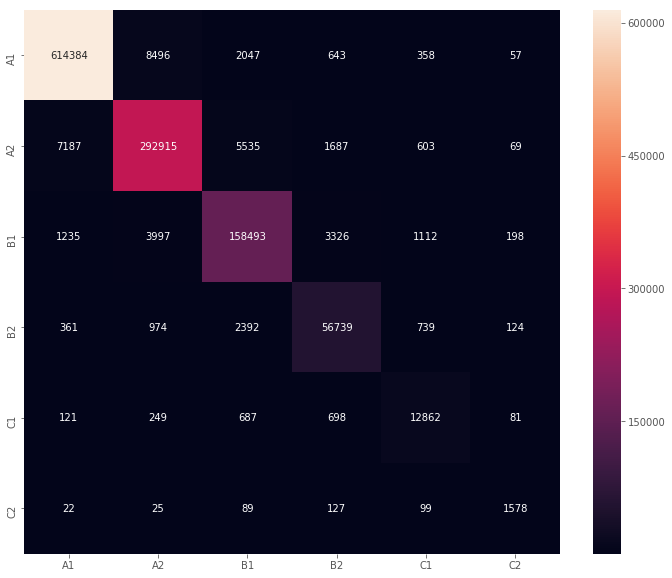

In [11]:
display_results(groups, groups_predicted)